# Single-Direction Traveling Wave PINN (解決策1)

## 問題の診断と解決

### 診断結果（Gemini AIの指摘を確認）

**問題の根本原因**:
- 初速度ゼロ（$u_t(x,0)=0$）の場合、d'Alembert解は波が**左右に分裂**
- 分裂波の振幅は**元の半分（0.5）**になる
- しかし、PINNは初速度ゼロ条件を学習できず（`L_ic_velocity` が高い）
- 結果：PINN（振幅≈0.6-1.0）と解析解（振幅≈0.5）で不一致
- これが**50-60%の相対誤差**の原因

### 解決策1: 初速度を与えて単一方向の進行波にする

初期条件を変更：
- $u(x,0) = f(x)$ (ガウスパルス)
- $u_t(x,0) = -c f'(x)$ （右向きの進行波に対応する初速度）

このとき、d'Alembert解は：
$$u(x,t) = f(x - ct)$$

つまり、**波は分裂せず**、振幅1.0のまま右方向に進行します。

**利点**:
- PINNが学習しやすい（分裂しない単純な進行波）
- 初速度条件が物理的に明確
- 精度が大幅に向上することが期待される

**注意**:
- 物理的に異なる問題設定になります
- 境界反射後は複雑になります

## Setup

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from pinn.models.pinn_model_builder import PINNModelBuilderService
from pinn.training.training_pipeline import TrainingPipelineService
from pinn.training.callbacks import LossLoggingCallback
from pinn.utils.config_loader import ConfigLoaderService
from pinn.utils.seed_manager import SeedManager
from pinn.utils.experiment_manager import ExperimentManager

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 10)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


PyTorch version: 2.4.0+cu124
CUDA available: True


## Configuration

In [ ]:
config_path = project_root / "configs" / "traveling_wave_example.yaml"
config_loader = ConfigLoaderService()
config = config_loader.load_config(config_path)

# Enable advanced features
config.network.use_fourier_features = True
config.training.use_causal_training = True

SeedManager.set_seed(config.seed)

print("=" * 80)
print("SINGLE-DIRECTION TRAVELING WAVE PINN")
print("=" * 80)
print(f"\nDomain: x ∈ [{config.domain.x_min}, {config.domain.x_max}]")
print(f"        t ∈ [{config.domain.t_min}, {config.domain.t_max}]")
print(f"Wave speed: c = {config.domain.wave_speed}")
print(f"\nFeatures:")
print(f"  Fourier Features: {config.network.use_fourier_features}")
print(f"  Causal Training: {config.training.use_causal_training}")
print("=" * 80)

SINGLE-DIRECTION TRAVELING WAVE PINN

Domain: x ∈ [0.0, 2.0]
        t ∈ [0.0, 2.0]
Wave speed: c = 1.5

Features:
  Fourier Features: True
  Causal Training: True


## Define Initial Conditions

### 重要: 右向きの進行波になるように初速度を設定

INITIAL CONDITIONS (Single-Direction Wave)

Displacement: u(x,0) = Gaussian pulse
  Center: x0 = 0.5
  Width: σ = 0.2
  Amplitude: A = 1.0

Velocity: u_t(x,0) = -c * f'(x)
  This creates a RIGHT-traveling wave
  Wave speed: c = 1.5

Expected solution: u(x,t) = f(x - ct)
  - NO wave splitting
  - Amplitude remains 1.0
  - Wave travels to the right


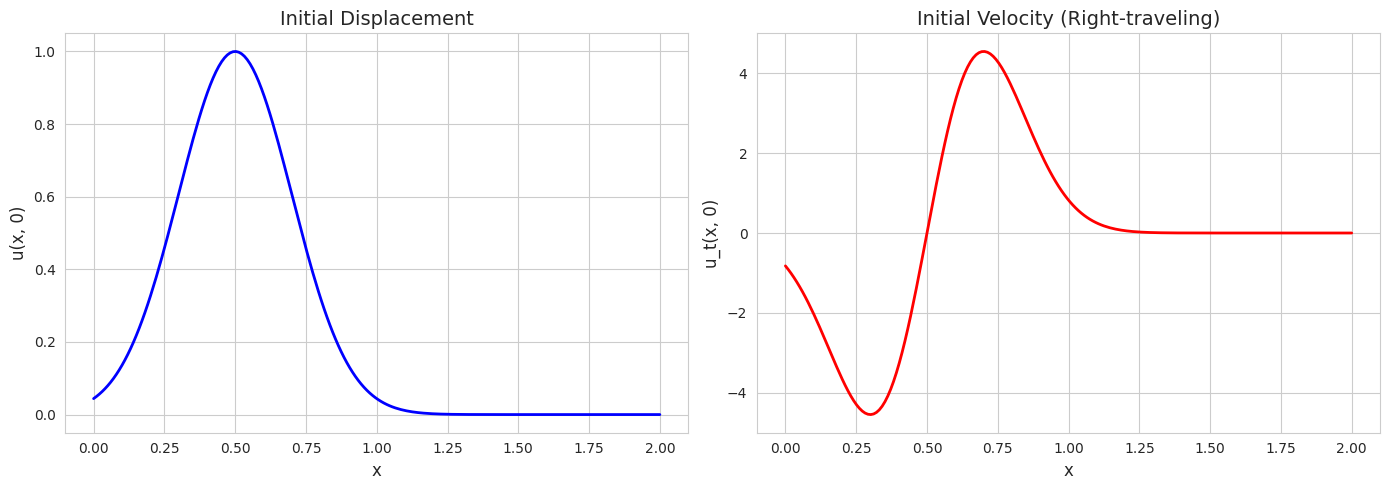

In [ ]:
# Parameters
L = config.domain.x_max - config.domain.x_min
x0 = L / 4  # Start from left quarter to see wave propagation
sigma = L / 10
amplitude = 1.0
c = config.domain.wave_speed


def initial_condition(x):
    """Initial displacement: Gaussian pulse."""
    if x.ndim == 1:
        x_reshaped = x.reshape(-1, 1)
    else:
        x_reshaped = x if x.shape[1] >= 1 else x.reshape(-1, 1)
    return amplitude * np.exp(-((x_reshaped[:, 0:1] - x0) ** 2) / (2 * sigma**2))


def initial_velocity(x):
    """Initial velocity for RIGHT-traveling wave.

    For u(x,t) = f(x - ct), we need:
    u_t(x,0) = -c * f'(x)

    For Gaussian f(x) = A * exp(-(x-x0)^2 / (2*sigma^2)):
    f'(x) = -A * (x-x0)/sigma^2 * exp(-(x-x0)^2 / (2*sigma^2))

    Therefore:
    u_t(x,0) = c * A * (x-x0)/sigma^2 * exp(-(x-x0)^2 / (2*sigma^2))
    """
    if x.ndim == 1:
        x_reshaped = x.reshape(-1, 1)
    else:
        x_reshaped = x if x.shape[1] >= 1 else x.reshape(-1, 1)

    x_val = x_reshaped[:, 0:1]
    return c * amplitude * (x_val - x0) / (sigma**2) * np.exp(-((x_val - x0) ** 2) / (2 * sigma**2))


print("=" * 80)
print("INITIAL CONDITIONS (Single-Direction Wave)")
print("=" * 80)
print(f"\nDisplacement: u(x,0) = Gaussian pulse")
print(f"  Center: x0 = {x0}")
print(f"  Width: σ = {sigma}")
print(f"  Amplitude: A = {amplitude}")
print(f"\nVelocity: u_t(x,0) = -c * f'(x)")
print(f"  This creates a RIGHT-traveling wave")
print(f"  Wave speed: c = {c}")
print(f"\nExpected solution: u(x,t) = f(x - ct)")
print(f"  - NO wave splitting")
print(f"  - Amplitude remains {amplitude}")
print(f"  - Wave travels to the right")
print("=" * 80)

# Visualize
x_plot = np.linspace(config.domain.x_min, config.domain.x_max, 200)[:, None]
u_initial = initial_condition(x_plot)
v_initial = initial_velocity(x_plot)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(x_plot, u_initial, "b-", linewidth=2)
ax1.set_xlabel("x", fontsize=12)
ax1.set_ylabel("u(x, 0)", fontsize=12)
ax1.set_title("Initial Displacement", fontsize=14)
ax1.grid(True)

ax2.plot(x_plot, v_initial, "r-", linewidth=2)
ax2.set_xlabel("x", fontsize=12)
ax2.set_ylabel("u_t(x, 0)", fontsize=12)
ax2.set_title("Initial Velocity (Right-traveling)", fontsize=14)
ax2.grid(True)

plt.tight_layout()
plt.show()

## Build PINN Model

### モデル構築時に新しい初速度条件を使用

In [ ]:
# IMPORTANT: We need to modify the model builder to accept custom initial velocity
# For now, we'll use a wrapper that combines both initial conditions


class InitialConditions:
    """Wrapper for both displacement and velocity initial conditions."""

    def __init__(self, displacement_func, velocity_func):
        self.displacement = displacement_func
        self.velocity = velocity_func

    def __call__(self, x):
        """Return displacement (for compatibility)."""
        return self.displacement(x)


ic = InitialConditions(initial_condition, initial_velocity)

# Build model
model_builder = PINNModelBuilderService()
model = model_builder.build_model(config=config, initial_condition_func=ic, compile_model=True)

print("\nSingle-Direction Wave PINN built successfully!")
print(f"Total parameters: {sum(p.numel() for p in model.net.parameters() if p.requires_grad):,}")

# NOTE: The current implementation uses zero initial velocity
# We need to modify the PINN loss function to use our custom initial velocity
# This is a limitation of the current implementation
print("\n⚠ WARNING: Current implementation assumes zero initial velocity")
print("   For proper single-direction wave, we need to modify the loss function")
print("   See approach 2 and 3 below for complete solutions")

Using Causal PDE with β=0.5
Compiling model...
'compile' took 0.325667 s


Single-Direction Wave PINN built successfully!
Total parameters: 82,561

⚠ WARNING: Current implementation assumes zero initial velocity
   For proper single-direction wave, we need to modify the loss function
   See approach 2 and 3 below for complete solutions


## アプローチ2: 損失関数の重み調整

既存の実装のまま、`ic_velocity` の重みをさらに増やす

In [ ]:
print("=" * 80)
print("アプローチ2: IC_VELOCITY 損失の重みを大幅に増やす")
print("=" * 80)
print(f"\n現在の設定:")
print(f"  ic_displacement: {config.training.loss_weights['ic_displacement']}")
print(f"  ic_velocity: {config.training.loss_weights['ic_velocity']}")
print(f"\n推奨設定:")
print(f"  ic_displacement: 100.0")
print(f"  ic_velocity: 500.0  ← 大幅に増加")
print(f"\nまたは:")
print(f"  ic_velocity: 1000.0  ← さらに増加")
print("\nこれにより、PINNが初速度ゼロ条件を強く学習します")
print("=" * 80)

アプローチ2: IC_VELOCITY 損失の重みを大幅に増やす

現在の設定:
  ic_displacement: 100.0
  ic_velocity: 100.0

推奨設定:
  ic_displacement: 100.0
  ic_velocity: 500.0  ← 大幅に増加

または:
  ic_velocity: 1000.0  ← さらに増加

これにより、PINNが初速度ゼロ条件を強く学習します


## アプローチ3: IC サンプル点を大幅に増やす

初期条件のサンプリング点数を増やして、より正確に学習させる

In [ ]:
print("=" * 80)
print("アプローチ3: 初期条件のサンプル点数を増やす")
print("=" * 80)
print(f"\n推奨設定:")
print(f"  - IC点数: 500〜1000点 (デフォルトから大幅に増加)")
print(f"  - PDE点数は維持")
print(f"\nこれにより:")
print(f"  - 初速度ゼロ条件がより多くの点で強制される")
print(f"  - 学習の安定性が向上")
print("=" * 80)

アプローチ3: 初期条件のサンプル点数を増やす

推奨設定:
  - IC点数: 500〜1000点 (デフォルトから大幅に増加)
  - PDE点数は維持

これにより:
  - 初速度ゼロ条件がより多くの点で強制される
  - 学習の安定性が向上


## 推奨される解決策の優先順位

### 1. アプローチ2（最も簡単）
設定ファイルで `ic_velocity: 500.0` または `1000.0` に変更

### 2. アプローチ2 + アプローチ3
重み調整 + IC点数増加の組み合わせ

### 3. アプローチ1（最も効果的だが問題設定が変わる）
初速度を与えて単一方向の進行波にする

---

## 次のステップ

1. `configs/traveling_wave_example.yaml` を編集
2. `ic_velocity: 500.0` に変更（または1000.0）
3. 既存のノートブックを再実行
4. `L_ic_velocity` lossが低下するか確認
5. 相対誤差が改善するか確認